Example for Figure 2A - Create a Single Cell Experiment object and then run DESeq2 on Excitatory neurons in C9-ALS (same process for rest)

In [1]:
library(tidyverse)
library(cowplot)
library(Matrix.utils)
library(edgeR)
library(Matrix)
library(reshape2)
library(S4Vectors)
library(SingleCellExperiment)
library(pheatmap)
library(apeglm)
library(png)
library(DESeq2)
library(RColorBrewer)
library(data.table)
library(Seurat)
set.seed(1234)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: limma


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package:

In [12]:
snRNA_V3only_C9ALS <- readRDS("/mnt/WORKHORSE/C9ALSFTLD_multiome/objects/snRNA_V3only_C9ALS_nodeep.RDS")

In [19]:
# Extract raw counts and metadata to create SingleCellExperiment (SCE) object
C9ALScounts <- snRNA_V3only_C9ALS_nodeep@assays$RNA@counts 

C9ALSmeta <- snRNA_V3only_C9ALS_nodeep@meta.data[,c("sample","sex","diagnoses", "class_clusters", "subclass_DE")]
table(C9ALSmeta$sample)
table(C9ALSmeta$diagnoses)
table(C9ALSmeta$sex)

# Create SCE object
C9ALSsce <- SingleCellExperiment(assays = list(counts = C9ALScounts), 
                                 colData = C9ALSmeta)

# Extract unique names for cell types and sample
cluster_names <- levels(colData(C9ALSsce)$class_clusters)
C9ALS_sample_names <- levels(colData(C9ALSsce)$sample)

# Subset metadata and pseudobulk
C9ALS_groups <- colData(C9ALSsce)[, c("class_clusters", "sample")]
C9ALSaggr_counts <- aggregate.Matrix(t(counts(C9ALSsce)),
                                     groupings = C9ALS_groups, fun = "sum")

# Transpose pseudobulk matrix (genes as rows and samples as columns)
C9ALSaggr_counts <- t(C9ALSaggr_counts)

#Organize pseudobulk matrix for SCE object
tstrsplit(colnames(C9ALSaggr_counts), "_") %>% str()
C9ALSidx <- which(tstrsplit(colnames(C9ALSaggr_counts), "_")[[1]] == "Excitatory")
C9ALSidx
C9ALScounts_ls <- list()

for (i in 1:length(cluster_names)) {
  C9ALS_column_idx <- which(tstrsplit(colnames(C9ALSaggr_counts), "_")[[1]] == cluster_names[i])
  C9ALScounts_ls[[i]] <- C9ALSaggr_counts[, C9ALS_column_idx]
  names(C9ALScounts_ls)[i] <- cluster_names[i]
  
}

# Sample-level variables, remove any duplicated rows
C9ALSmetadata <- colData(C9ALSsce) %>%
  as.data.frame() %>%
  dplyr::select(diagnoses, sex, sample)
C9ALSmetadata <- C9ALSmetadata[!duplicated(C9ALSmetadata), ]

# Rename metadata rows by sample
rownames(C9ALSmetadata) <- C9ALSmetadata$sample
head(C9ALSmetadata)

# Number of cells per sample and cluster
C9ALSt <- table(colData(C9ALSsce)$sample,
                colData(C9ALSsce)$class_clusters)

C9ALS_metadata_ls <- list()

for (i in 1:length(C9ALScounts_ls)) {
  C9ALS_df <- data.frame(cluster_sample = colnames(C9ALScounts_ls[[i]]))
  C9ALS_df$class_clusters <- tstrsplit(C9ALS_df$cluster_sample, "_")[[1]]
  C9ALS_df$sample  <- tstrsplit(C9ALS_df$cluster_sample, "_")[[2]]
  C9ALSidx <- which(colnames(C9ALSt) == unique(C9ALS_df$class_clusters))
  C9ALS_cell_counts <- C9ALSt[, C9ALSidx]
  C9ALS_cell_counts <- C9ALS_cell_counts[C9ALS_cell_counts > 0]
  C9ALS_sample_order <- match(C9ALS_df$sample, names(C9ALS_cell_counts))
  C9ALS_cell_counts <- C9ALS_cell_counts[C9ALS_sample_order]
  C9ALS_df$cell_count <- C9ALS_cell_counts
  C9ALS_df <- plyr::join(C9ALS_df, C9ALSmetadata,
                         by = intersect(names(C9ALS_df), names(C9ALSmetadata)))
  rownames(C9ALS_df) <- C9ALS_df$cluster_sample
  C9ALS_metadata_ls[[i]] <- C9ALS_df
  names(C9ALS_metadata_ls)[i] <- unique(C9ALS_df$class_clusters)
}


       CTRL1        CTRL2        CTRL3        CTRL4        CTRL5        CTRL6 
        2672         4602         2687         5131         6665         4209 
  C9ALSFTLD1   C9ALSFTLD2   C9ALSFTLD3   C9ALSFTLD4 C9ALSnoFTLD1 C9ALSnoFTLD3 
        3805         7151         7808         4310         8309         5670 


control   C9ALS 
  25966   37053 


female   male 
 34522  28497 

List of 2
 $ : chr [1:72] "Oligodendrocytes" "OPC" "Astrocytes" "Microglia-PVM" ...
 $ : chr [1:72] "CTRL1" "CTRL1" "CTRL1" "CTRL1" ...


[1]  5 11 17 23 29 35 41 47 53 59 65 71

,diagnoses,sex,sample
,<fct>,<chr>,<fct>
CTRL1,control,female,CTRL1
CTRL2,control,male,CTRL2
CTRL3,control,female,CTRL3
CTRL4,control,male,CTRL4
CTRL5,control,female,CTRL5
CTRL6,control,female,CTRL6


In [20]:
# Select cluster to create DESeq2 object (Excitatory neurons example)
idx <- which(names(C9ALScounts_ls) == "Excitatory")
C9ALS_cluster_counts <- C9ALScounts_ls[[idx]]
C9ALS_cluster_metadata <- C9ALS_metadata_ls[[idx]]

# Create DESeq2 object
C9ALS_dds <- DESeqDataSetFromMatrix(C9ALS_cluster_counts,
                                    colData = C9ALS_cluster_metadata,
                                    design = ~ diagnoses + sex)

C9ALS_rld <- rlog(C9ALS_dds, blind = TRUE)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


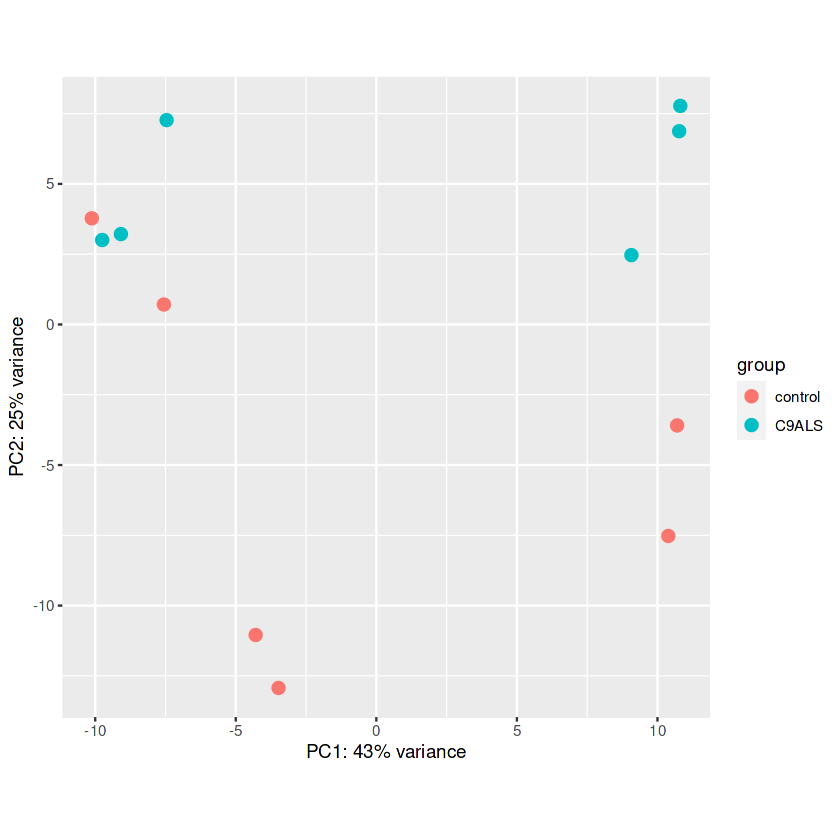

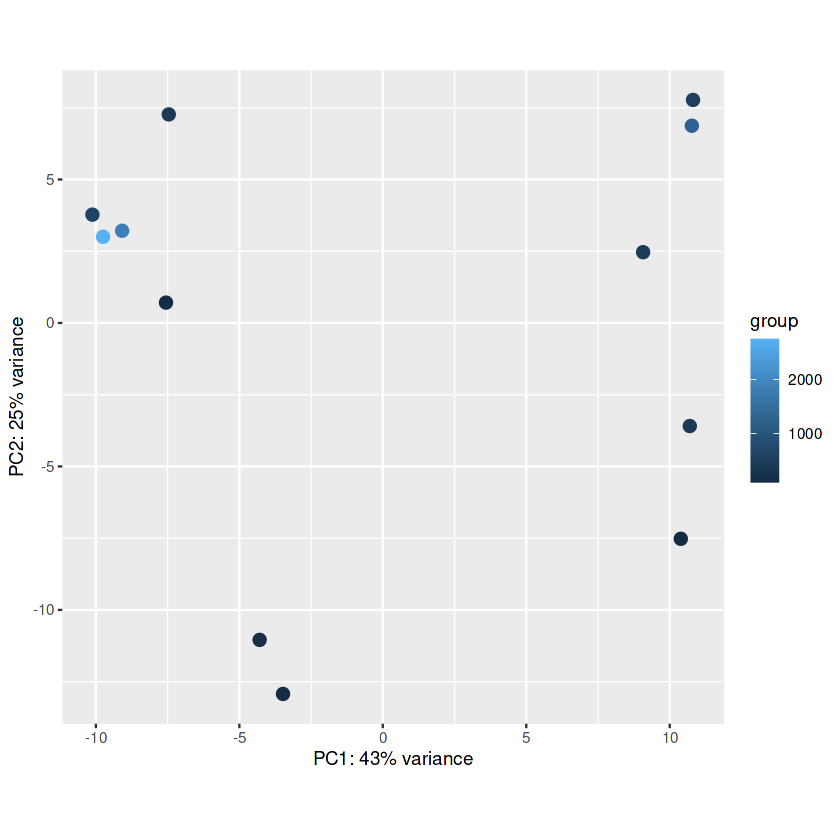

In [24]:
# Plot DESeq2 PCA
DESeq2::plotPCA(C9ALS_rld, ntop = 100, intgroup = "diagnoses")
DESeq2::plotPCA(C9ALS_rld, ntop = 100, intgroup = "cell_count")

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Excitatory_CTRL1        Excitatory_CTRL2        Excitatory_CTRL3 
              0.1124777               0.9604286               0.3001397 
       Excitatory_CTRL4        Excitatory_CTRL5        Excitatory_CTRL6 
              0.2789704               1.8829601               0.4847677 
  Excitatory_C9ALSFTLD1   Excitatory_C9ALSFTLD2   Excitatory_C9ALSFTLD3 
              1.1575817               2.1432861               1.6735881 
  Excitatory_C9ALSFTLD4 Excitatory_C9ALSnoFTLD1 Excitatory_C9ALSnoFTLD3 
              0.9937121               7.3296542               4.3038947

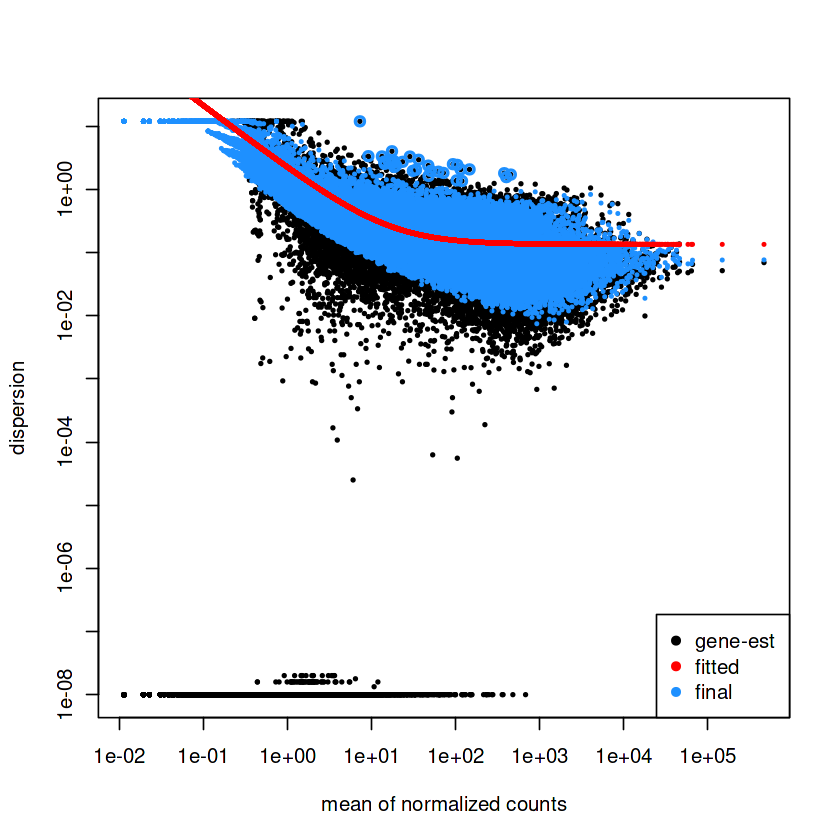

In [26]:
# Run DESeq2 for C9-ALS vs control
C9ALS_dds <- DESeq(C9ALS_dds)

# Plot dispersion estimates
plotDispEsts(C9ALS_dds)
C9ALS_dds$sizeFactor

In [27]:
# Generate results object
C9ALS_res <- results(C9ALS_dds,
                     name = "diagnoses_C9ALS_vs_control",
                     alpha = 0.05)

# Use apeglm to shrink lfc appropriately
C9ALS_res <- lfcShrink(C9ALS_dds,
                       coef = "diagnoses_C9ALS_vs_control",
                       res=C9ALS_res,
                       type = "apeglm")

# Create tibble object for ease of exploration
C9ALS_res_tbl <- C9ALS_res %>%
  data.frame() %>%
  rownames_to_column(var = "gene") %>%
  as_tibble() %>%
  arrange(padj)

# Set thresholds
padj_cutoff <- 0.01

# Subset the significant results
C9ALS_sig_res <- dplyr::filter(C9ALS_res_tbl, padj < padj_cutoff) %>%
  dplyr::arrange(padj)
# Set thresholds
log2fc_cutoff <- 0.5

# Count significantly up/down genes above threshold
C9ALS_n_sig_up <- dplyr::filter(C9ALS_sig_res, log2FoldChange >= log2fc_cutoff) %>% 
  nrow()
C9ALS_n_sig_dn <- dplyr::filter(C9ALS_sig_res, log2FoldChange <= -log2fc_cutoff) %>% 
  nrow()

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



gene,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CLDN8,0,NA,NA,NA,NA
KRTAP6-2,0,NA,NA,NA,NA
LINC00163,0,NA,NA,NA,NA
GAGE12F,0,NA,NA,NA,NA
PAGE3,0,NA,NA,NA,NA
TTTY17C,0,NA,NA,NA,NA


,Excitatory_CTRL1,Excitatory_CTRL2,Excitatory_CTRL3,Excitatory_CTRL4,Excitatory_CTRL5,Excitatory_CTRL6,Excitatory_C9ALSFTLD1,Excitatory_C9ALSFTLD2,Excitatory_C9ALSFTLD3,Excitatory_C9ALSFTLD4,Excitatory_C9ALSnoFTLD1,Excitatory_C9ALSnoFTLD3
CLCA4,17.781308,8.329615,23.322473,39.43071,9.028338,8.251375,3.455480,1.866293,4.182630,1.006328,1.500753,1.858782
IFI16,71.125231,138.479841,163.257310,268.84576,123.210261,57.759623,31.099317,29.860690,45.411412,18.113898,38.473848,37.407978
TDRD5,0.000000,35.400862,26.654255,21.50766,41.424140,33.005499,143.402408,95.180949,72.897267,93.588475,85.270053,102.465332
WNT9A,0.000000,0.000000,3.331782,3.58461,12.745889,8.251375,47.512846,24.728384,56.166747,39.246780,36.427367,41.357889
DISC1,106.687847,66.636916,109.948801,39.43071,56.294344,113.456403,105.392131,149.770022,243.787581,164.031413,529.492922,372.221003
VRK2,542.329888,84.337347,256.547202,232.99966,38.768746,103.142185,14.685789,29.394116,41.826301,35.221469,19.373356,16.264338
TRIM36,248.938309,130.150227,179.916219,200.73817,459.383086,363.060490,810.309993,509.964592,573.020320,709.461019,820.775423,567.625413
AL033523.1,462.314002,41.648073,49.976728,103.95369,23.367463,10.314218,8.638699,12.597478,4.780149,9.056949,6.412308,7.202778
TMEM243,115.578501,98.914172,186.579783,86.03064,94.532011,158.838964,399.107907,440.911747,216.899245,666.188929,274.228491,260.229416
CLEC2L,248.938309,153.056667,176.584438,125.46135,215.617957,311.489398,402.563387,325.668147,339.988073,539.391640,376.825419,529.055696


Warning message:
“Transformation introduced infinite values in continuous y-axis”


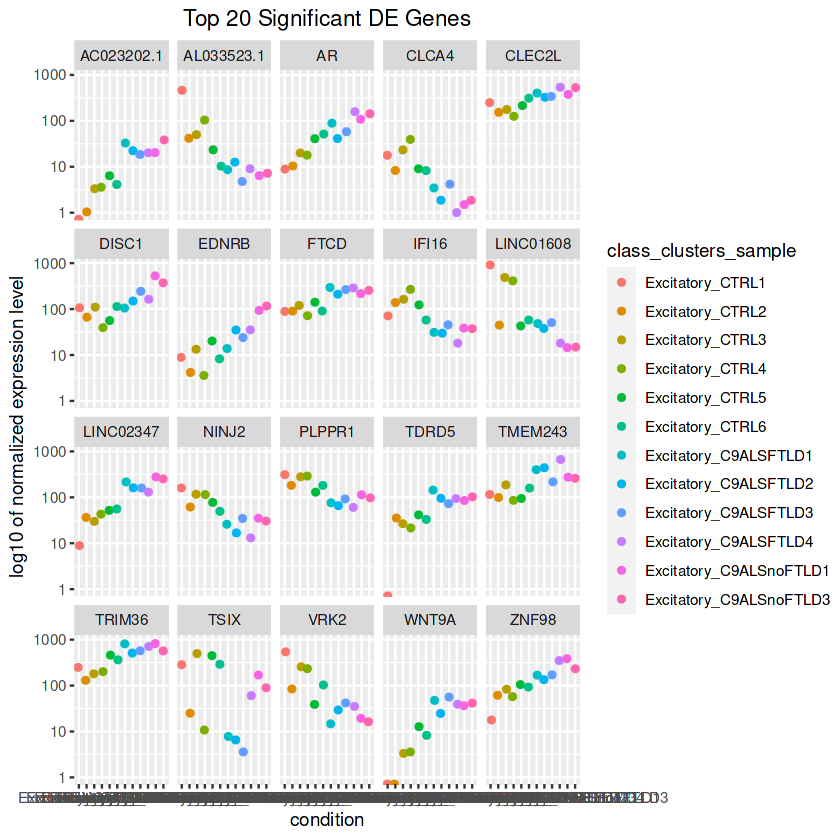

In [28]:
## Generate scatterplot of top 20 DEGs
C9ALS_normalized_counts <- counts(C9ALS_dds, normalized = TRUE)
C9ALS_top20_sig_genes <- C9ALS_sig_res %>%
  dplyr::arrange(padj) %>%
  dplyr::pull(gene) %>%
  head(n = 20)

C9ALS_top20_sig_counts <- C9ALS_normalized_counts[rownames(C9ALS_normalized_counts) %in% C9ALS_top20_sig_genes, ]
C9ALS_top20_sig_counts

C9ALS_top20_sig_df <- data.frame(C9ALS_top20_sig_counts)
C9ALS_top20_sig_df$gene <- rownames(C9ALS_top20_sig_counts)
C9ALS_top20_sig_df <- melt(setDT(C9ALS_top20_sig_df),
                           id.vars = c("gene"),
                           variable.name = "class_clusters_sample") %>%
  data.frame()

ggplot(C9ALS_top20_sig_df, aes(y = value, x = class_clusters_sample, col = class_clusters_sample)) +
  geom_jitter(height = 0, width = 0.15) +
  scale_y_continuous(trans = 'log10') +
  ylab("log10 of normalized expression level") +
  xlab("condition") +
  ggtitle("Top 20 Significant DE Genes") +
  theme(plot.title = element_text(hjust = 0.5)) +
  facet_wrap(~ gene)

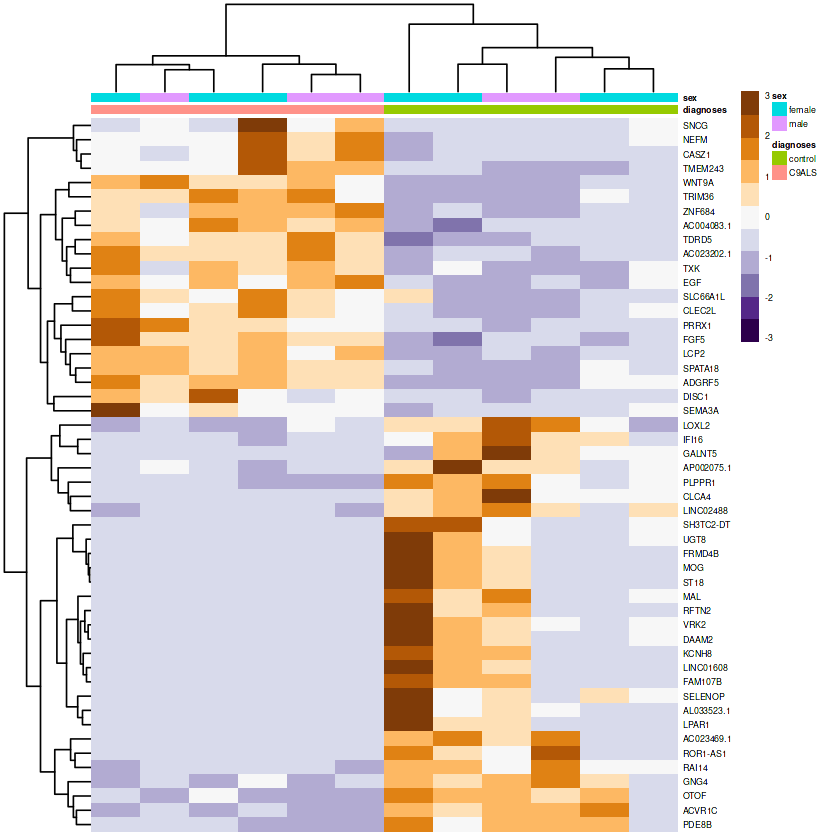

In [30]:
# Heatmap used in manuscript

# Extract normalized counts for significant genes only
C9ALS_sig_counts <- C9ALS_normalized_counts[rownames(C9ALS_normalized_counts) %in% C9ALS_sig_res$gene, ]

#Palette for heatmap
heat_colors <- rev(brewer.pal(11, "PuOr"))

# Run pheatmap using the metadata data frame for the annotation, plot top 50 genes
C9ALS_exc_heatmap <- pheatmap(C9ALS_sig_counts[1:50,],
                              color = heat_colors,
                              cluster_rows = TRUE,
                              show_rownames = TRUE,
                              show_colnames = FALSE,
                              annotation = C9ALS_cluster_metadata[, c("diagnoses", "sex")], 
                              border_color = NA,
                              fontsize = 5,
                              scale = "row",
                              fontsize_row = 5,
                              height = 20)

[1] -9.915866

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


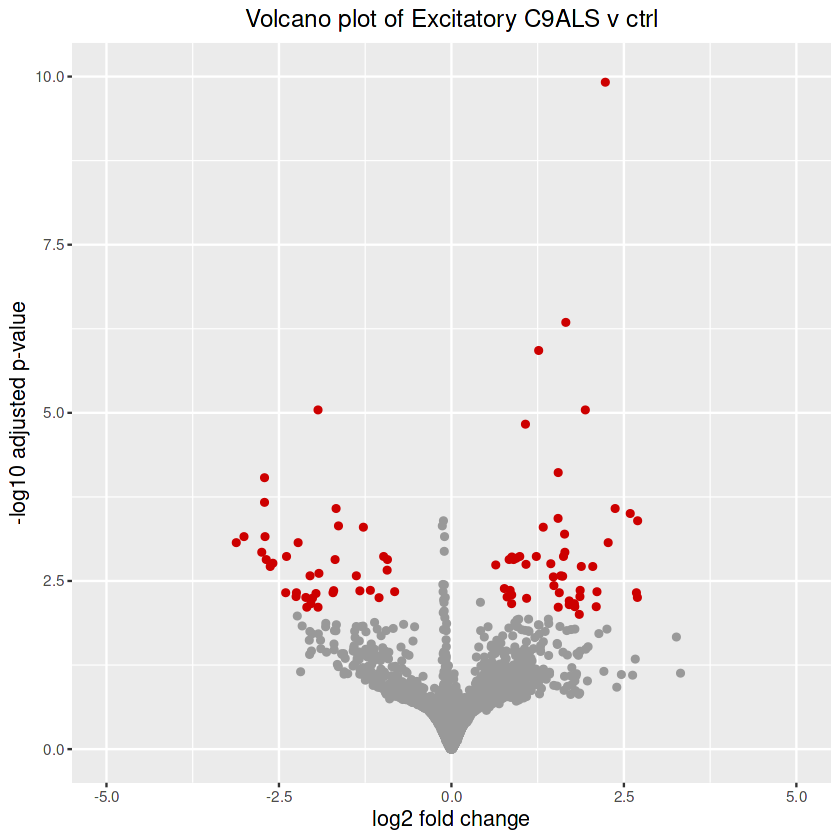

In [31]:
# Generate Volcano plot of findings for supplement
C9ALS_res_table_thres <- C9ALS_res_tbl[!is.na(C9ALS_res_tbl$padj), ] %>% 
  mutate(threshold = padj < padj_cutoff & abs(log2FoldChange) >= log2fc_cutoff)
min(log10(C9ALS_res_table_thres$padj))
ggplot(C9ALS_res_table_thres) +
  geom_point(aes(x = log2FoldChange, y = -log10(padj), colour = threshold)) +
  ggtitle("Volcano plot of Excitatory C9ALS v ctrl") +
  xlab("log2 fold change") +
  xlim(-5, 5) +
  ylab("-log10 adjusted p-value") +
  scale_y_continuous(limits = c(0, 10)) +
  scale_color_manual(values = c("grey60", "red3")) +
  theme(legend.position = "none",
        plot.title = element_text(size = rel(1.3), hjust = 0.5),
        axis.title = element_text(size = rel(1.15)))                    
